# MANUALLY DETERMINE TRANSFECTION EFFECIENCY

This code is useful to manually determine the transfection effeciency of cells! 

This code uses imaged cells saved as a single z-slice image separated into two pictures by channel. Channel 1 here is DAPI/nuclear staining which is ulitmately used to determine the total number of cells and is signified by "chan1" or "1" throughout the code. Channel 2 here, signified as "chan2" or "2", is the channel where the transfected cells can be visualized, usually from a 488, rhodamine, or 647 dye. To use this code, you will simply input the path to your images and run the cells. For areas where more input is required, the markdown cells will provide instructions. When you have questions, the commented code in the cells may provide answers.

## BEGIN BY LOADING THE MODULES

In [11]:
#standard modules
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt

#for image processing
import scipy
import skimage
import skimage.io
import skimage.exposure
import skimage.measure
import skimage.filters
import skimage.morphology
from skimage.morphology import reconstruction
import PIL
from PIL import Image
import cv2

#to allow for inline rendering of plots
%matplotlib inline

## LOAD THE IMAGES

Only change the path to your image here, DO NOT change the variable names, as this will render the rest of the script invalid.

In [12]:
#load the image with the DAPI stain as "chan 1" by providing the path to the file 
chan1 = skimage.io.imread(r'Z:\Michelle\CSC593\10_Series001-1.tif') #put your unique file path in place of, 
                                                                    #"r'Z:\Michelle\CSC593\10_Series001-1.tif'"
#load the image with the transfected cells as "chan 2" by providing the path to the file
chan2 = skimage.io.imread(r'Z:\Michelle\CSC593\10_Series001-2.tif') 

## Quality checks -- not neccessary, but can be helpful

In [6]:
#if you want to check the numpy arrays produced from the loaded images, uncomment and run the following code

#print(chan1)
#print(chan2)

In [16]:
#if you wnat to check to make sure that the arrays are the right data type/ have the right dimensions,
#this code will be useful
#if the output of this function ("valid_img_data") returns false and tells you it is not 2 or 3D, 
#then make sure that you have a single z slice and channel

def valid_img_data(chan):
    data = np.asarray(chan)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

#to run this function to check the validity of your images/numpy arrays, uncomment the following four lines of code:
    
#valid_chan1 = valid_img_data(chan1)
#valid_chan2 = valid_img_data(chan2)
#print(valid_chan1)
#print(valid_chan2)

## VISUALIZE YOUR IMAGES 

Load them by setting a black and white color map. You do not need them loaded as RGB images because you will be thresholding them.

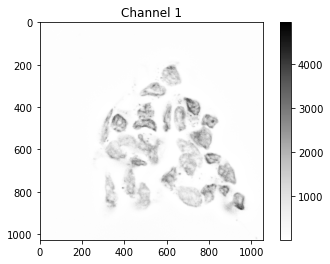

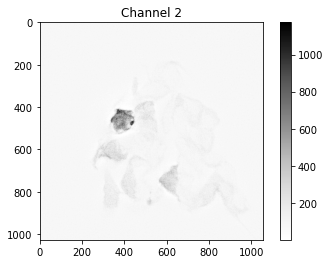

In [10]:
#set the colormap for data display
grey = plt.cm.Greys_r
reversed_grey = grey.reversed() #need to invert the colors b/c microscopy channels show up lighter than the background

#load the images 
fig1 = plt.figure(1)
plt.imshow(chan1, cmap=reversed_grey)
plt.title("Channel 1")
plt.colorbar()

fig2 = plt.figure(2)
plt.imshow(chan2, cmap=reversed_grey)
plt.title("Channel 2")
plt.colorbar()

#show both pictures
plt.show()

## NORMALIZE THE IMAGES

As you can see in the figures above, the scales on the color bar are different for each channel! They should be normalized so that both reflect the same scale. This is a good practice and requires normalizing the pixel values so that each pixel value has a value between 0 and 1

In [20]:
#this function can be called to normalize the images, it will give you an output which tells you the
#data type, and the min and max pixel values from the original images, and after the normalization
#if the function works properly, the min after normalization should be 0.000 and the max should be 1.000

def normalize_chan(chan):
    pixels = asarray(chan)
    #check the pixel range
    print("Data type: %s" % pixels.dtype) 
    print("Min: %.3f, Max: %.3f" % (pixels.min(), pixels.max()))
    pixels = pixels.astype('float32') #make integers floats
    #normalize to range of 0-1
    pixels /= pixels.max()
    print("Min: %.3f, Max: %.3f" % (pixels.min(), pixels.max()))
    return pixels

norm_chan1 = normalize_chan(chan1)
norm_chan2 = normalize_chan(chan2)

#if you'd like to see the resulting normalized arrays, uncomment and run the following code:
#print(norm_chan1)
#print(norm_chan2)

Data type: float32
Min: 0.091, Max: 4948.359
Min: 0.000, Max: 1.000
Data type: float32
Min: 0.304, Max: 1173.773
Min: 0.000, Max: 1.000


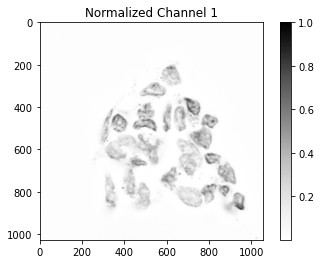

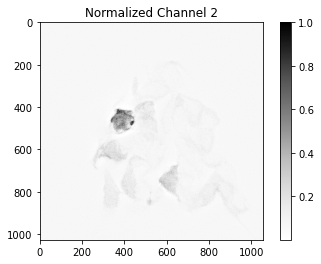

In [22]:
## RE-LOAD THE IMAGES AS THE NORMALIZED DATA
# This step isn't necessary but is another check to ensure that the normalization worked, 
# if it worked, the color-bar indicating the pixels for the images should now range from 0-1

#load the images as the normalized data
norm_fig1 = plt.figure(1)
plt.imshow(norm_chan1, cmap=reversed_grey) #use the grey/reversed_grey colormap outlined earlier for the display
plt.title("Normalized Channel 1")
plt.colorbar()

norm_fig2 = plt.figure(2)
plt.imshow(norm_chan2, cmap=reversed_grey)
plt.title("Normalized Channel 2")
plt.colorbar()

#show both pictures
plt.show()

## DETERMINE THE THRESHOLD MANUALLY WITH HISTOGRAM

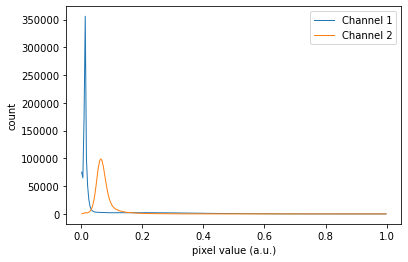

In [24]:
#generate histogram of the channel images
hist_chan1, bins_chan1 = skimage.exposure.histogram(norm_chan1)
hist_chan2, bins_chan2 = skimage.exposure.histogram(norm_chan2)

#plot each histogram over one another
plt.plot(bins_chan1, hist_chan1, label='Channel 1', linewidth=1)
plt.plot(bins_chan2, hist_chan2, label='Channel 2', linewidth=1)
plt.xlabel('pixel value (a.u.)')
plt.ylabel('count')
plt.legend()

#the outcome of the histogram will tell us which value is best to use as a threshold
#you want to use the value after the peak that works best for both channels

## PLOT THE TWO IMAGES WITH THEIR THRESHOLDS 

And compare against the original un-thresholded images to make sure it worked!

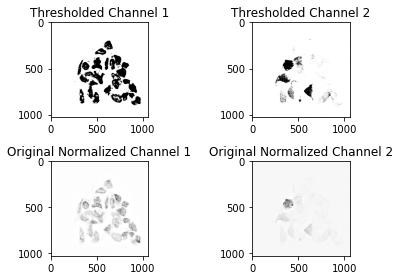

In [26]:
#apply the threshold, this is the value you determine based on the histogram above and will,
#be stored as the variable "thresh_val"
thresh_val = 0.15
thresh_chan1 = norm_chan1 > thresh_val
thresh_chan2 = norm_chan2 > thresh_val

# Set up the axes for plotting 
fig, ax = plt.subplots(nrows=2, ncols=2) # This generates two rows of images with two columns,
                                        # and assigns them to variable "ax"

# Plot the first image
ax[0,0].imshow(thresh_chan1, cmap=reversed_grey)
ax[0,0].set_title("Thresholded Channel 1")

# Plot the second image
ax[0,1].imshow(thresh_chan2, cmap=reversed_grey)
ax[0,1].set_title("Thresholded Channel 2")

# Plot the original (un-thresholded) first image
ax[1,0].imshow(norm_chan1, cmap=reversed_grey)
ax[1,0].set_title("Original Normalized Channel 1")

# Plot the original (un-thresholded) second image
ax[1,1].imshow(norm_chan2, cmap=reversed_grey)
ax[1,1].set_title("Original Normalized Channel 2")

plt.tight_layout() #this avoids the titles being crowded when plotted

## COUNTING CELLS

Now that we've found the threshold and confirmed that it works by comparing the images to the originals, we can start to get closer to finding out the transfection effeciency ratio by counting the cells!

In [27]:
#the "skimage.measure.label" function will count the number of particles in the image
#it does this by identifying "islands" of pixels above the threshold (marked as 1.0's) 
#in a sea of background pixels (marked as 0's) 
#it will return an image where each isolated object is marked with a single value 
#it will also return the total number of objects

# Label each individual cell 
im_lab1, num_obj1 = skimage.measure.label(thresh_chan1, return_num=True)
im_lab2, num_obj2 = skimage.measure.label(thresh_chan2, return_num=True)
                                   
# Print out how many objects were identified
print("Number of objects found in 1: %s" %num_obj1)
print("Number of objects found in 2: %s" %num_obj2)

Number of objects found in 1: 382
Number of objects found in 2: 2012


Woah! That's way too many objects to be correct! Visually double check the numbers of objects found in the images against to see if the numbers seem right. Chances are they are not right! This is because the particles being counted in the images include small pixels that do not represent cells. To count actual cells, we need to filter out these particles.

## FIND THE AREAS OF PARTICLES/CELLS IN THE IMAGE

And visualize them as a range of values on a histogram

<module 'matplotlib.pyplot' from 'C:\\Users\\mjgregoire\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

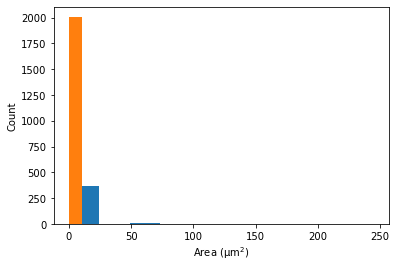

In [28]:
# if you want to find the actual real-life size of the cells, 
# you need to convert pixels to physical units 

#ip_dist stands for inter-pixel distance. It is unique to each camera! Check your camera's specs to find this number
ip_dist_63x = 0.1036339 # this number is in units of microns per pixel, Leica DMi8 has 103 nm,
                        #interpixel distance at 63x magnification, hence "ip_dist_63x"
    
#if your images are from Leica DMi8 but are not at 63x magnification,
#uncomment the following code to convert the ip_dist values between magnifications:
#ip_dist_minus_magnification = 0.1036339*63 # to find out the value for the camera alone, multiply by the magnification
#ip_dist_10x =  (ip_dist_minus_magnification / 10) #this will give you the pixel distance for 10x magnifcation
                                                   # you can change the 10 to reflect your magnifcation level

def area_hist(num_obj, im_lab):
    areas = np.zeros(num_obj) #make empty area the same size as num_obj
    for i in range(num_obj): #loop through and
        cell = (im_lab == i + 1) #grab "cells" one by one
        areas[i] = np.sum(cell) * ip_dist_63x**2 #convert pixels to physical units
    plt.hist(areas,bins=10)
    plt.xlabel("Area (µm$^2$)")
    plt.ylabel("Count")
    return plt

area_hist(num_obj1, im_lab1)
area_hist(num_obj2, im_lab2)

Look at the count of the insanely small particles near 0! These need to be filtered out.

## FILTER THE SMALL PARTICLES OUT OF THE THRESHOLD

Based on the histogram above, determine a range of cell sizes that you think are valid. You can also reference the average size of the type of cells you imaged if that is helpful. You will need to input the smallest size of this range and the largest size in the filtering functions below.

In [35]:
#to filter out the small particles, load the following two functions,
#and change the cell sizes based on your range

#the following function will give you a picture of the cells that pass the filtering overlayed on the original figure
#it will also print how many cells it detects or "segments"
def filter_particles_pic(thresh_chan, num_obj, im_lab, norm_chan):
    approved_cells = np.zeros_like(thresh_chan) #make empty image same size as threshold image
    for i in range(num_obj): #loop through and
        cell = (im_lab == i + 1) #grab "cells" one by one
        cell_area = np.sum(cell) * ip_dist_63x**2 #convert pixels to physical units
        if (cell_area > 20) & (cell_area <200): # <-----INPUT YOUR RANGE HERE
            approved_cells += cell #add the cells that make the cutoff to the empty image
    approved_lab, num_obj = skimage.measure.label(approved_cells, return_num=True)
    print("Segmented %s single cells." %num_obj)
    plt.imshow(approved_lab, cmap = reversed_grey)
    #now plot the filtered cells onto the original normalized image
    copy = np.copy(norm_chan)
    # Give the segmented pixels a value of 1.0
    copy[approved_cells] = 1.0
    # Make an RGB image to compare the thresholded cells as a mask on the original 
    mask_rgb = np.dstack((norm_chan, copy, copy))
    plt.imshow(mask_rgb)
    return plt

#the following function is used to ultimately save the number of cells that pass the,
#filtering process to a variable which is used in the transfection effeciency ratio
def filter_particles_num(thresh_chan, num_obj, im_lab):
    approved_cells = np.zeros_like(thresh_chan) #make empty image same size as threshold image
    for i in range(num_obj): #loop through and
        cell = (im_lab == i + 1) #grab "cells" one by one
        cell_area = np.sum(cell) * ip_dist_63x**2 #convert pixels to physical units
        if (cell_area > 20) & (cell_area <200): # <-----INPUT YOUR RANGE HERE
            approved_cells += cell #add the cells that make the cutoff to the empty image
    approved_lab, num_obj = skimage.measure.label(approved_cells, return_num=True)
    x = num_obj
    print("Segmented cells =", x)
    return x

Run the functions for each channel and get the total number of identified cells after the filtering and an overlay of the filtered cells onto the original images.

Segmented 14 single cells.


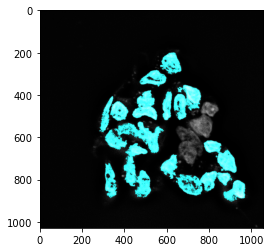

In [30]:
filtered_chan1 = filter_particles_pic(thresh_chan1, num_obj1, im_lab1, norm_chan1)

Segmented 5 single cells.


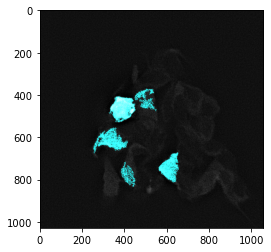

In [31]:
filtered_chan2 = filter_particles_pic(thresh_chan2, num_obj2, im_lab2, norm_chan2)

## FINALLY YOU CAN DETERMINE THE TRANSFECTION EFFECIENCY RATIO!!

In [37]:
#run the "filter_particles_num" function and save the output to a variable to call in the transfection ratio equation
number_cells_chan1 = filter_particles_num(thresh_chan1, num_obj1, im_lab1)
number_cells_chan2 = filter_particles_num(thresh_chan2, num_obj2, im_lab2)

Transfection_ratio = (number_cells_chan2)/(number_cells_chan1)*100 
print("The transfection ratio is", Transfection_ratio, "%")

Segmented cells = 14
Segmented cells = 5
The transfection ratio is 35.714285714285715 %
